In [ ]:
import pandas as pd
import numpy as np
import jax
from IPython.display import Markdown, display
import jax.numpy as jnp
from numpyro.infer import MCMC, NUTS
from tqdm import tqdm
import arviz as az
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
import numpyro
from jax import random
import numpyro.distributions as dist
import warnings
warnings.simplefilter('ignore')
import seaborn as sns
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.contrib.control_flow import scan
from tqdm import tqdm
import arviz as az
import matplotlib.pyplot as plt
from IPython.display import display, Math
import matplotlib.dates as mdates
import warnings
warnings.simplefilter('ignore')

class ProgressBar:
    def __init__(self, total):
        self.pbar = tqdm(total=total, desc="Sampling Progress", position=0, leave=True)

    def update(self, value):
        self.pbar.update(value)

    def close(self):
        self.pbar.close()

---
## Real data
### Period 
1983-2018 Q
### Output gap
Beveridge-Nelson Filter (https://bnfiltering.com)

### Inflation Expectation
Fed of Cleveland (https://www.clevelandfed.org/indicators-and-data/inflation-expectations)

one year inflation expectation
### Inflation rate
FRED (https://fred.stlouisfed.org/series/CPIAUCSL)

Consumer Price Index for All Urban Consumers: All Items in U.S. City Average 

---

In [16]:
data_cpi = pd.read_csv("data/CPIAUCSL.csv", parse_dates=["DATE"])
data_cpi.set_index("DATE", inplace=True)
data_cpi = data_cpi.resample("QS").mean()
data_cpi['pi'] = data_cpi['CPIAUCSL'].pct_change() * 100
data_cpi = data_cpi['pi']
data_cpi = data_cpi.reset_index()

data_gap = pd.read_csv("data/BN_filter_GDPC1_quaterly.csv")
data_gap['Y'] = data_gap["cycle"]
data_gap['DATE'] = data_gap["date"]
data_gap = data_gap[["DATE", "Y"]]

data_Epi = pd.read_csv("data/one_year_inflation_expectation.csv")
data_Epi['DATE'] = pd.to_datetime(data_Epi['Model Output Date'])
data_Epi.set_index("DATE", inplace=True)
data_Epi = data_Epi[[" 1 year Expected Inflation"]].resample("QS").mean() * 100 / 4
data_Epi['Epi'] = data_Epi[' 1 year Expected Inflation']
data_Epi = data_Epi.reset_index()
data_Epi = data_Epi[["DATE", "Epi"]]

data_cpi['DATE'] = pd.to_datetime(data_cpi['DATE'])
data_gap['DATE'] = pd.to_datetime(data_gap['DATE'])
data_Epi['DATE'] = pd.to_datetime(data_Epi['DATE'])

data = pd.merge(data_cpi, data_Epi, on="DATE", how="outer")
data = pd.merge(data, data_gap, on="DATE", how="outer")

data["pi_prev"] = data["pi"].shift(1)
data["Y_prev"] = data["Y"].shift(1)
data.dropna(inplace=True)
# data = data[data['DATE'] < '2008-07-01']

# for MCMC
pi = jnp.array(data['pi'])
pi_prev = jnp.array(data['pi_prev'])
pi_expect = jnp.array(data['Epi'])
Y = jnp.array(data['Y'])
Y_prev = jnp.array(data['Y_prev'])

## Estimation

The observed variable $\pi_t$ is the inflation rate, $\text{E}\pi_t$ is the expected inflation rate, and $\text{gap}_t$ is the output gap


In [91]:
warmup= 10000
samples=40000
chains = 2
rng_key = jax.random.PRNGKey(0)

In [ ]:

def set_prior_distributions():
    priors = {
        # observation equation params
        "beta" : dist.Uniform(0, 1),
        "kappa": dist.Gamma(concentration=2, rate=10),
        "theta": dist.Gamma(concentration=2, rate=10),
        # state equation params
        "rho_z"     : dist.Gamma(concentration=2, rate=10),
        "rho_kappa" : dist.Gamma(concentration=2, rate=10),
        # sigma
        "sigma_eps": dist.HalfCauchy(scale=0.1),
        "sigma_eta": dist.HalfCauchy(scale=0.1),
        "sigma_kappa": dist.HalfCauchy(scale=0.1)
    }
    return priors
#--------------------------------------------------------------------------------
# z_{t-1}
def model_1(pi, pi_expect, Y, l):
    # Parameters
    priors = set_prior_distributions()
    beta   = numpyro.sample("beta", priors["beta"])
    theta  = numpyro.sample("theta", priors["theta"])
    kappa_init = numpyro.sample("kappa_init", priors["kappa"])
    z_init = 1
    # state equation params
    rho_kappa = numpyro.sample("rho_kappa", priors["rho_kappa"])
    rho_z     = numpyro.sample("rho_z",     priors["rho_z"])
    # sigma
    sigma_eta   = numpyro.sample("sigma_eta",   priors["sigma_eta"])
    sigma_eps   = numpyro.sample("sigma_e",     priors["sigma_eps"])
    sigma_kappa = numpyro.sample("sigma_kappa", priors["sigma_kappa"])
    timesteps = jnp.arange(l)
    t = 0
    
    # state space model
    def transition(carry, _):
        # t-1
        z_prev = carry[0]
        kappa_prev = carry[1]
        t = carry[2]

        kappa = numpyro.sample("kappa", numpyro.distributions.TruncatedNormal(rho_kappa * kappa_prev, sigma_kappa, low=0))
        z = numpyro.sample("z", numpyro.distributions.Normal(rho_z * z_prev, sigma_eta))
        pi_pred = beta * pi_expect[t] + kappa * Y[t] - theta * z
        numpyro.sample(f"pi_obs", numpyro.distributions.Normal(pi_pred, sigma_eps), obs=pi[t])
        t_carry = t + 1
        z_carry = z
        kappa_carry = kappa
        return [z_carry, kappa_carry, t_carry], None
    scan(transition, [z_init, kappa_init, t], timesteps)

# RUN MCMC
kernel = NUTS(model_1)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc.run(rng_key, pi=pi, pi_expect=pi_expect, Y=Y, l=len(pi))
idata = az.from_numpyro(mcmc)

# Results
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples["z"]
z_mean = np.mean(z_samples, axis=0) 
z_std = np.std(z_samples, axis=0)  
z_lower = z_mean - 1.96 * z_std     
z_upper = z_mean + 1.96 * z_std  

kappa_samples = posterior_samples["kappa"]
kappa_mean = np.mean(kappa_samples, axis=0) 
kappa_std = np.std(kappa_samples, axis=0)  
kappa_lower = kappa_mean - 1.96 * kappa_std     
kappa_upper = kappa_mean + 1.96 * kappa_std  



sample: 100%|██████████| 50000/50000 [01:37<00:00, 514.06it/s, 127 steps of size 2.86e-02. acc. prob=0.95]


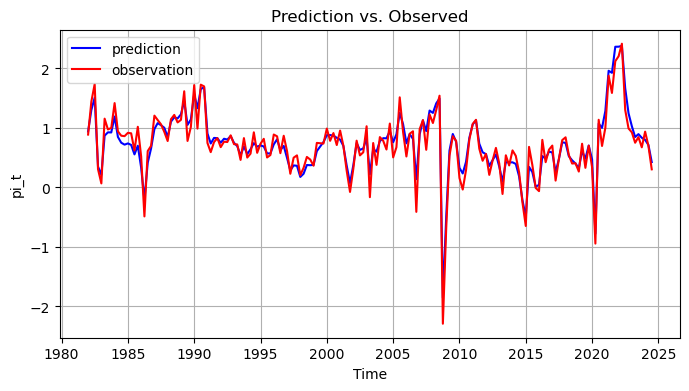

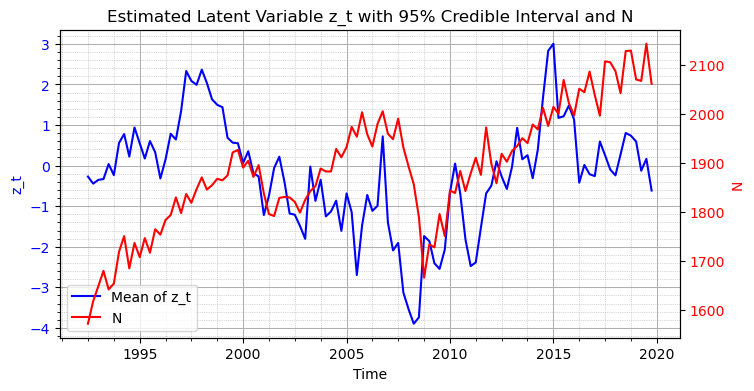

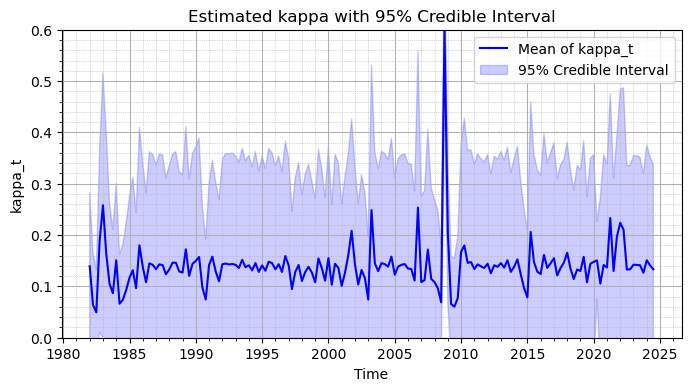

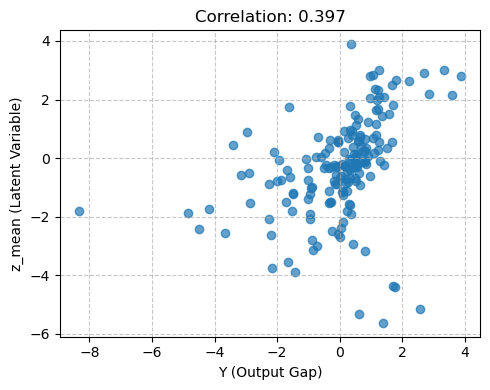

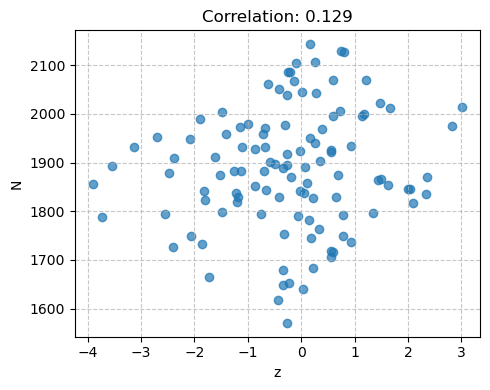

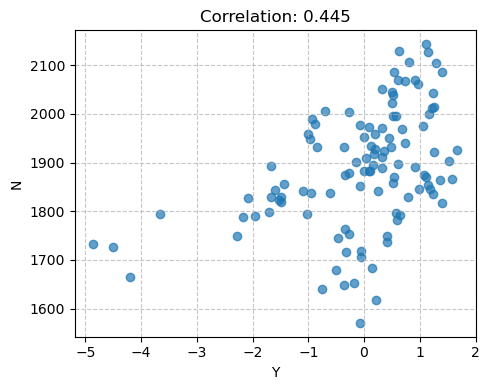

In [108]:
if "theta" in idata.posterior.data_vars:
    theta_mean_value = float(idata.posterior["theta"].mean(dim=["chain", "draw"]))
else:
    theta_mean_value = 0
if "alpha" in idata.posterior.data_vars:
    alpha_mean_value = float(idata.posterior["alpha"].mean(dim=["chain", "draw"]))
else:
    alpha_mean_value = 0

beta_mean_value  = float(idata.posterior["beta"].mean(dim=["chain", "draw"]))

pi_pred = alpha_mean_value * data["pi_prev"] + beta_mean_value * data["Epi"] + kappa_mean * data["Y"] - theta_mean_value * z_mean


df = data
df["z"] = z_mean
data_N = pd.read_csv("data/BLS-bd-BDS0000000000000000120001LQ5.csv")
data_N["N"] = data_N["National – Gross Job Gains – Number of Establishments – Total private – National – Private Sector – Quarterly – Level – Seasonally Adjusted – All size classes – U.S. totals – Establishment (BLS/bd/BDS0000000000000000120001LQ5)"].shift(-1)
data_N['q'] = data_N["period"]
data_N["q"] = data_N["q"].str.replace(" ", "")
data_N["DATE"] = data_N["q"].apply(lambda x: pd.Period(x, freq="Q").start_time)
data_N = data_N[["DATE", "N"]]
df_merged = pd.merge(df, data_N, on="DATE", how="outer")
df_merged = df_merged.dropna()
df_merged = df_merged[df_merged['DATE'] < '2020-01-01']


# Plot
plt.figure(figsize=(8, 4))
plt.plot(data["DATE"], pi_pred, label="prediction", color="blue")
plt.plot(data["DATE"], data["pi"], label="observation", color="red")
plt.title("Prediction vs. Observed")
plt.xlabel("Time")
plt.ylabel("pi_t")
plt.legend()
plt.grid(True)
plt.show()
# print(f"Bayesian R^2: {r2}")

import matplotlib.dates as mdates

fig, ax1 = plt.subplots(figsize=(8, 4))

# 左軸にz_tのプロット
ax1.plot(df_merged["DATE"], df_merged["z"], label="Mean of z_t", color="blue")
ax1.set_xlabel("Time")
ax1.set_ylabel("z_t", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")
ax1.xaxis.set_major_locator(mdates.YearLocator(5))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.xaxis.set_minor_locator(mdates.YearLocator(1))

# 右軸にNのプロット
ax2 = ax1.twinx()
ax2.plot(df_merged["DATE"], df_merged["N"], label="N", color="red")
ax2.set_ylabel("N", color="red")
ax2.tick_params(axis='y', labelcolor="red")

# 凡例の作成（2軸の凡例をまとめる）
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="best")

ax1.minorticks_on()
ax1.grid(which='major', linestyle='-', linewidth=0.75)
ax1.grid(which='minor', linestyle=':', linewidth=0.5)

plt.title("Estimated Latent Variable z_t with 95% Credible Interval and N")
plt.show()


plt.figure(figsize=(8, 4))
plt.plot(data["DATE"], kappa_mean, label="Mean of kappa_t", color="blue")
plt.fill_between(data["DATE"], kappa_lower, kappa_upper, color="blue", alpha=0.2, label="95% Credible Interval")
plt.title("Estimated kappa with 95% Credible Interval")
plt.xlabel("Time")
plt.ylabel("kappa_t")
plt.ylim(0, 0.6)
plt.legend()
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth=0.75)
plt.grid(which='minor', linestyle=':', linewidth=0.5)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
plt.show()


corrcoef = np.corrcoef(z_mean, data["Y"])[0, 1]
plt.figure(figsize=(5, 4))
plt.scatter(data["Y"],z_mean, alpha=0.7)
plt.xlabel("Y (Output Gap)")
plt.ylabel("z_mean (Latent Variable)")
plt.title(f"Correlation: {corrcoef:.3f}")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

corrcoef = np.corrcoef(df_merged["z"], df_merged["N"])[0, 1]
plt.figure(figsize=(5, 4))
plt.scatter(df_merged["z"],df_merged["N"], alpha=0.7)
plt.xlabel("z")
plt.ylabel("N")
plt.title(f"Correlation: {corrcoef:.3f}")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

corrcoef = np.corrcoef(df_merged["Y"], df_merged["N"])[0, 1]
plt.figure(figsize=(5, 4))
plt.scatter(df_merged["Y"],df_merged["N"], alpha=0.7)
plt.xlabel("Y")
plt.ylabel("N")
plt.title(f"Correlation: {corrcoef:.3f}")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()